# Random forest for pianist classification

This is the primary notebook used to generate the analysis and plots in the following paper:


```
@misc{cheston_schlichting_cross_harrison_2024,
 title={Rhythmic Qualities of Jazz Improvisation Predict Performer Identity and Style in Source-Separated Audio Recordings},
 url={osf.io/preprints/psyarxiv/txy2f},
 DOI={10.31234/osf.io/txy2f},
 publisher={PsyArXiv},
 author={Cheston, Huw and Schlichting, Joshua L and Cross, Ian and Harrison, Peter M C},
 year={2024},
 month={Jan}
}
```

## Import dependencies, set constants etc.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from joblib import Parallel, delayed, dump
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.inspection._permutation_importance import _weights_scorer, _create_importances_bunch
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import check_scoring
from sklearn.model_selection import StratifiedKFold, ParameterSampler, train_test_split, ParameterGrid
from sklearn.utils import check_random_state
from statsmodels.stats.outliers_influence import variance_inflation_factor

import src.visualise.visualise_utils as vutils
from src import utils
from src.detect.onset_utils import OnsetMaker
from src.features.rhythm_features import *
from src.visualise.random_forest_plots import *

In [2]:
# These variables are used for the optimization process
SEED = 42
N_FOLDS = 5
N_JOBS = -1
# Number of iterations to use in random sampling
N_ITER = 10000

In [3]:
# Set the seed in NumPy for consistent results across function calls
np.random.seed(SEED)

## Define predictor and prediction variables, get mappings

In [4]:
# Define target/prediction variables
EXOG_INS = 'piano'
PREDICTION = 'pianist'

In [5]:
# These are the underlying categories each predictor belongs to
PREDICTORS_CATEGORIES = {
    'Swing': ['bur_log_mean', 'bur_log_std'],
    'Complexity': ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std'],
    'Feel': ['bass_prop_async_nanmean', 'drums_prop_async_nanmean', 'bass_prop_async_nanstd', 'drums_prop_async_nanstd'],
    'Interaction': ['self_coupling', 'coupling_drums', 'coupling_bass', 'coupling_piano_drums', 'coupling_piano_bass'],
    'Tempo': ['rolling_std_median', 'tempo', 'tempo_slope', 'missing_beats_perc']
}
PREDICTORS = [it for sl in list(PREDICTORS_CATEGORIES.values()) for it in sl]

In [6]:
# This creates a dictionary for mapping a predictor onto its category
CATEGORY_MAPPING = {}
for pred in PREDICTORS:
    for category in PREDICTORS_CATEGORIES.keys():
        if pred in PREDICTORS_CATEGORIES[category]:
            CATEGORY_MAPPING[pred] = category

## Load in data

First, we load in our list of `src.detect.detect_utils.OnsetMaker` classes. These contain the location of detected onsets and beats, as well as additional metadata.

In [7]:
# Get filepaths for processing: this should point towards an extracted .zip from the GitHub releases page
root = f'{utils.get_project_root()}/data/jazz-trio-database-v02/'
onsets_all = utils.load_corpus_from_files(root)

In [8]:
# Subset to just get JTD-300 tracks
jtd300 = set(i['fname'] for i in utils.CorpusMaker.from_excel('corpus_updated', only_30_corpus=True).tracks)
onsets = [o for o in onsets_all if o.item['fname'] in jtd300]

## Extract features

Now, we can extract our desired feature from each OnsetMaker class.

In [9]:
def get_feature_data(feature_cls, cols, extra_str = '', **cls_kwargs):
    """Creates a class with given kwargs and returns the desired key-value pairs from its summary dictionary"""
    cls = feature_cls(**cls_kwargs)
    return {k + extra_str: v for k, v in cls.summary_dict.items() if k in cols}

In [10]:
def process_track(track: OnsetMaker) -> dict:
    """Processes a single track, extracting all required features, and returns a dictionary"""
    # Convert the summary dictionary (dictionary of arrays) to a dataframe
    summary_dict = pd.DataFrame(track.summary_dict)
    # These are the positions of downbeats, i.e. the first beat of a measure
    downbeats = track.ons['downbeats_auto']
    # These are the beat timestamps from the matched onsets
    band_beats = get_beats_from_matched_onsets(track.summary_dict)
    # Subset to get my onsets and partner onsets as separate dataframes
    my_onsets = track.ons[EXOG_INS]
    my_beats = summary_dict[EXOG_INS]
    their_beats = summary_dict[[i for i in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys() if i != EXOG_INS]]
    # The tempo and time signature of the track
    tempo = (60 / band_beats.diff()).mean()
    time_signature = track.item['time_signature']
    # The percentage of beats that are missing for this musician
    missing_beats_perc = 1 - (len(my_beats.dropna()) / len(summary_dict))    
    # BEAT-UPBEAT RATIO
    bur = get_feature_data(
        BeatUpbeatRatio, ['bur_log_mean', 'bur_log_std', 'bur_log_count_nonzero'],
        my_onsets=my_onsets, my_beats=my_beats, clean_outliers=True
    )
    # PHASE CORRECTION
    pc = get_feature_data(
        PhaseCorrection, ['self_coupling', 'coupling_bass', 'coupling_drums', 'nobs'],
        my_beats=my_beats, their_beats=their_beats, order=1
    )
    # PHASE CORRECTION - PARTNER
    # In comparison to the 'full' phase correction model, we only need to get a few columns here
    pcb = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_bass',
        my_beats=summary_dict['bass'], their_beats=summary_dict[['piano', 'drums']], order=1
    )
    pcd = get_feature_data(
        PhaseCorrection, ['coupling_piano', 'nobs'], extra_str='_drums',
        my_beats=summary_dict['drums'], their_beats=summary_dict[['piano', 'bass']], order=1
    )
    # PROPORTIONAL ASYNCHRONY
    pa = get_feature_data(
        ProportionalAsynchrony, ['prop_async_count_nonzero', 'bass_prop_async_nanmean', 'drums_prop_async_nanmean', 'bass_prop_async_nanstd', 'drums_prop_async_nanstd'],
        summary_df=summary_dict, my_instr_name=EXOG_INS, metre_col='metre_auto'
    )
    # IOI COMPLEXITY
    ioi = get_feature_data(
        IOIComplexity, ['lz77_mean', 'lz77_std', 'n_onsets_mean', 'n_onsets_std', 'window_count', 'ioi_count'],
        my_onsets=my_onsets, downbeats=downbeats, tempo=tempo, time_signature=time_signature
    )
    # TEMPO SLOPE
    ts = get_feature_data(
        TempoSlope, ['tempo_slope', 'tempo_drift'],
        my_beats=band_beats
    )
    # TEMPO STABILITY
    tstab = get_feature_data(
        RollingIOISummaryStats, ['rolling_std_count_nonzero', 'rolling_std_median'],
        my_onsets=my_beats, downbeats=downbeats, bar_period=4
    )
    # Return a single dictionary that combines the summary dictionary for all the features
    return dict(**track.item, **bur, **pc, **pcb, **pcd, **pa, **ioi, **ts, **tstab, tempo_man=tempo, missing_beats_perc=missing_beats_perc)

Now, we extract features from all tracks in parallel (should take < 5 minutes)

In [11]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    res = parallel(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   17.7s finished


We can now convert all of these features to a dataframe, sort by the pianist in the recording, and print a few rows.

In [12]:
df = (
    pd.DataFrame(res)
    .drop(columns='tempo')
    .rename(columns=dict(tempo_man='tempo'))
    .sort_values('bandleader')
    .reset_index(drop=True)
)

In [13]:
df[PREDICTORS].describe()

,bur_log_mean,bur_log_std,lz77_mean,lz77_std,n_onsets_mean,n_onsets_std,bass_prop_async_nanmean,drums_prop_async_nanmean,bass_prop_async_nanstd,drums_prop_async_nanstd,self_coupling,coupling_drums,coupling_bass,coupling_piano_drums,coupling_piano_bass,rolling_std_median,tempo,tempo_slope,missing_beats_perc
count,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,300.000000,299.000000,298.000000,300.000000,300.000000,300.000000,300.000000
mean,0.414159,0.586548,11.349304,1.612672,27.654278,6.104475,0.010819,0.014169,0.005367,0.007105,-0.512119,0.604915,0.405997,0.139417,0.155023,0.026170,194.995623,0.659951,0.280625
std,0.273696,0.174599,1.044064,0.397296,6.507245,2.838610,0.009376,0.008256,0.003955,0.004130,0.103792,0.374147,0.328441,0.127754,0.176260,0.010347,50.023832,11.003543,0.087994
min,-0.390964,0.165666,7.601744,0.967988,12.852941,1.727700,-0.017973,-0.008319,-0.006506,-0.005457,-0.837820,-0.284727,-1.053702,-0.132514,-0.867925,0.012260,103.472478,-0.483454,0.007843
25%,0.249016,0.461211,10.757827,1.336318,22.968913,3.927119,0.004743,0.008367,0.002686,0.004481,-0.576899,0.381656,0.245069,0.057465,0.068610,0.018338,154.031578,-0.002677,0.223020
50%,0.388927,0.536872,11.348493,1.508261,26.550549,5.108995,0.010797,0.013593,0.005066,0.006908,-0.515366,0.564741,0.398969,0.118189,0.133582,0.023565,191.673420,0.023005,0.284784
75%,0.559111,0.686626,11.983402,1.829695,30.478122,7.702484,0.017420,0.019714,0.007881,0.009779,-0.457311,0.773183,0.543591,0.200359,0.219934,0.031515,224.638726,0.058305,0.337706
max,1.416962,1.185276,14.053571,3.645670,51.103448,14.791164,0.032908,0.034672,0.017611,0.021381,-0.013455,2.973005,2.015080,0.756249,1.169631,0.075016,299.824125,190.607801,0.553488


In [14]:
# df['rolling_std_median'] = df['rolling_std_median'] / (60 / df['tempo'])

## Plot correlations between features
Before we clean outliers, we should plot the correlations between the raw values

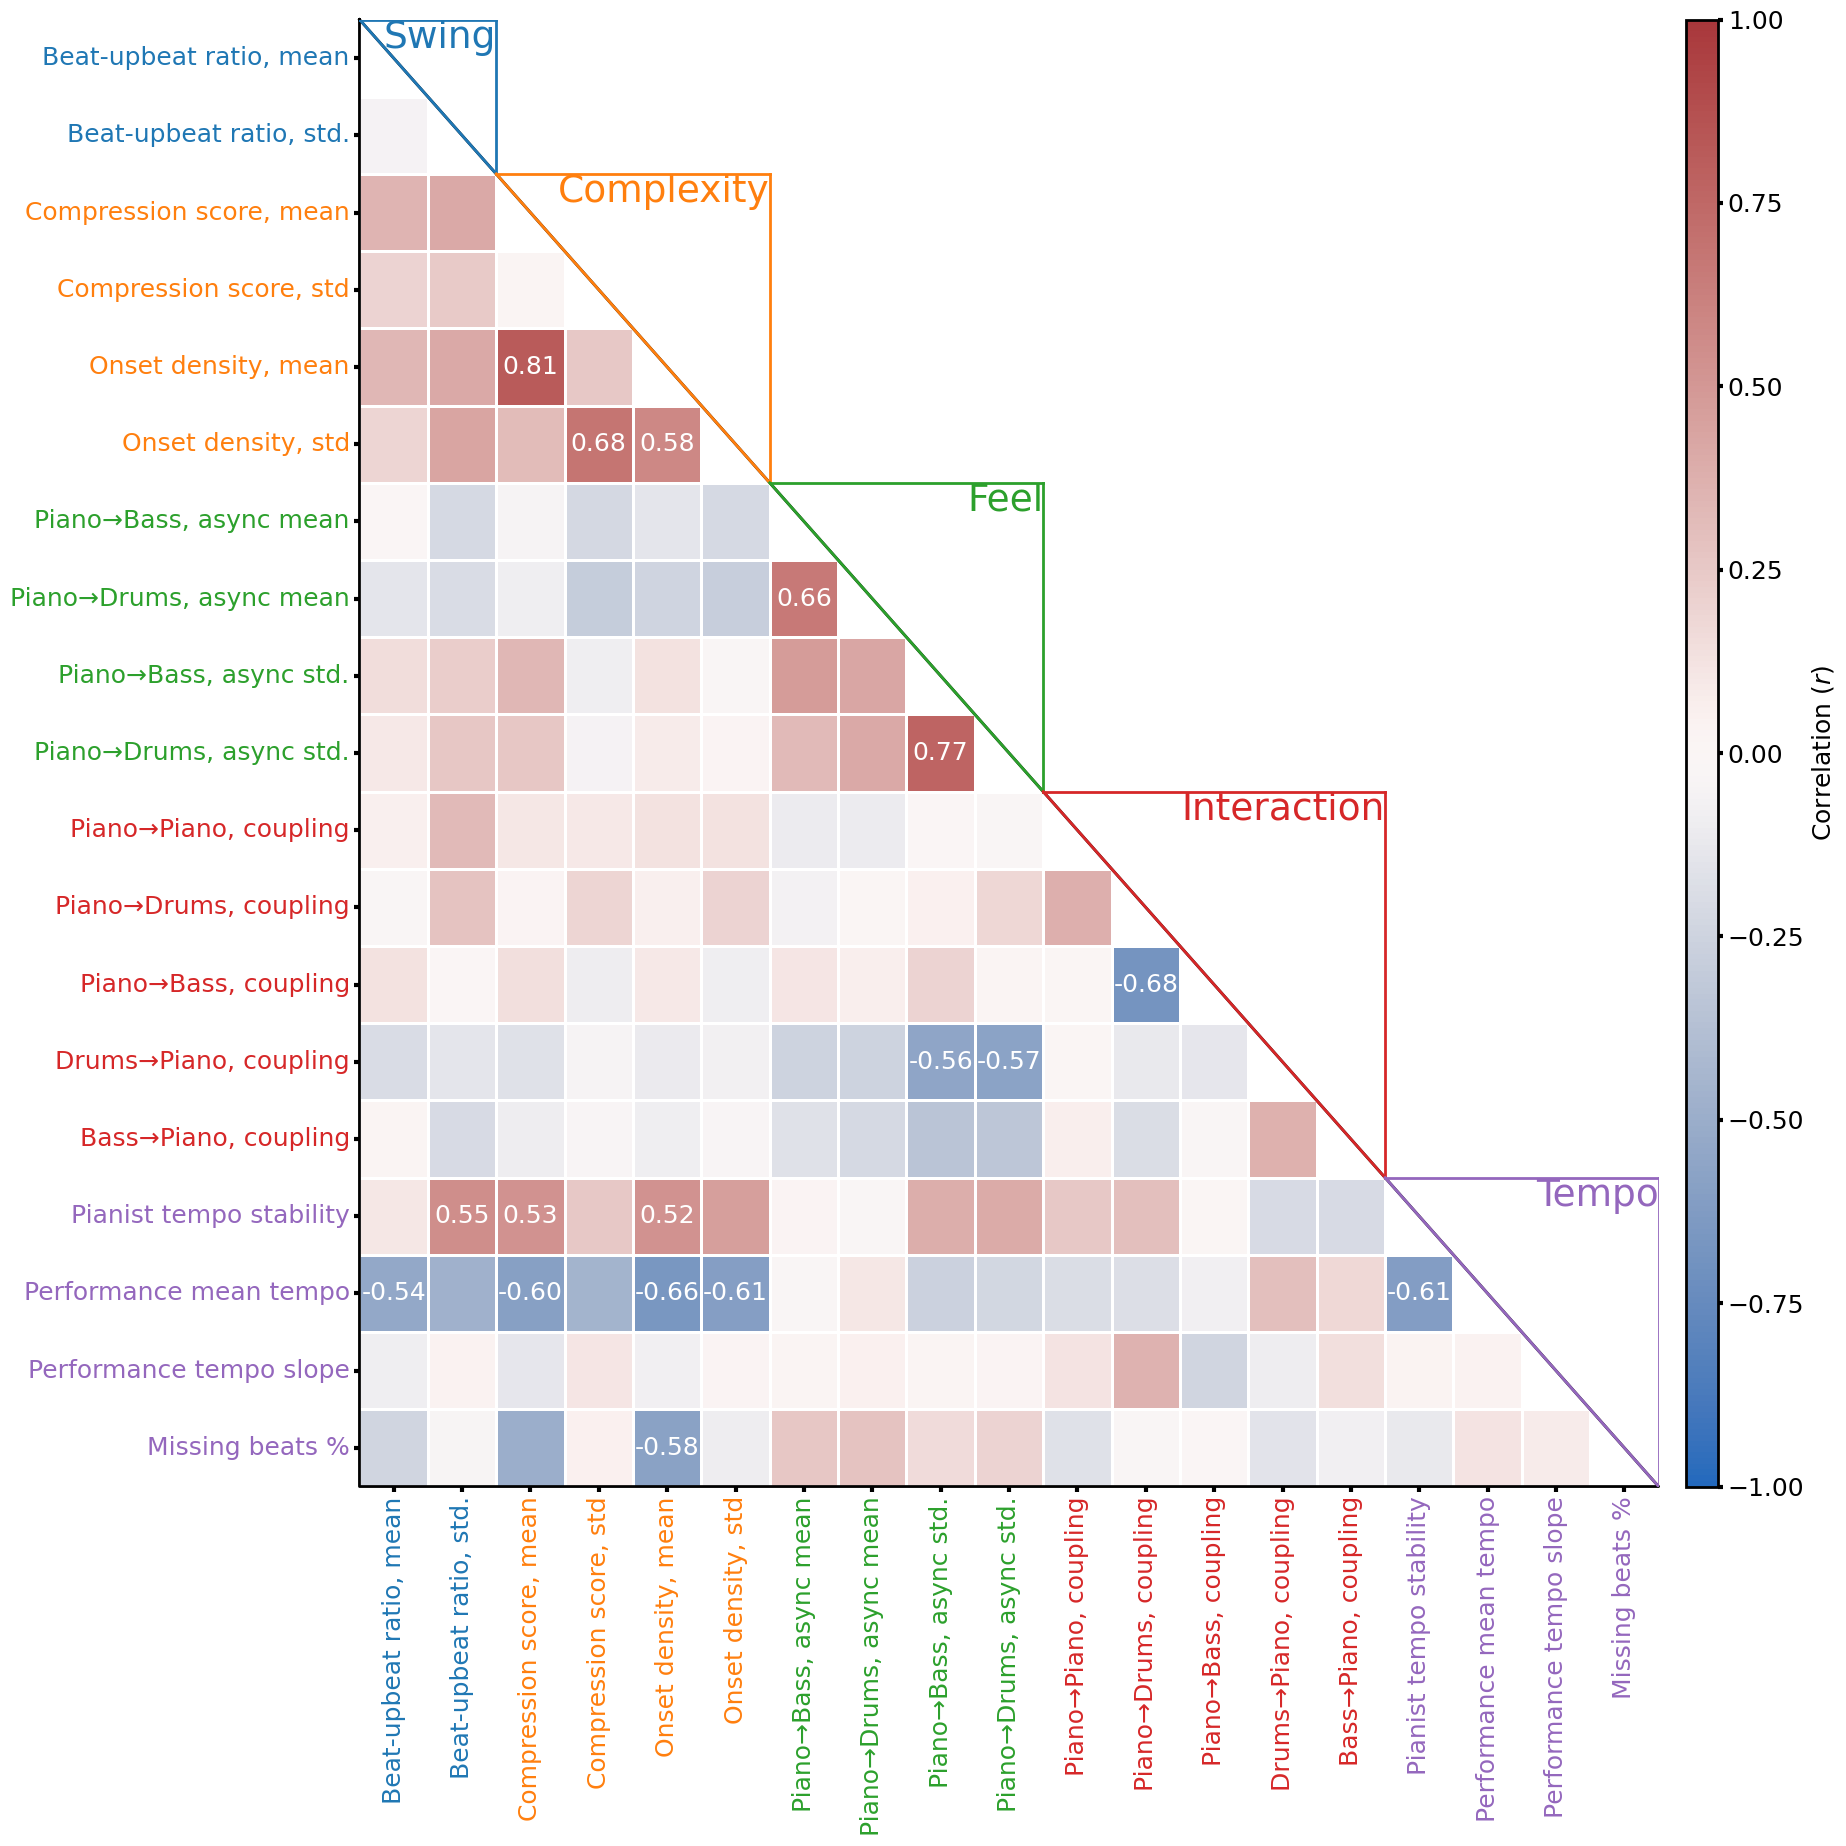

In [15]:
HeatMapFeatureCorrelation(df[PREDICTORS]).create_plot()
plt.show()

## Clean dataset
### Identify outliers
When cleaning the dataset, we first need to identify outlying values in our features. We set outlying values to `np.nan` so that we can set them to the overall average later, rather than removing the track completely. To start, we clean `self_coupling`, `coupling_bass`, or `coupling_drums` when `nobs < 30`: this means that we have fewer than 10 terms for each of our 3 predictors in the regression.

In [16]:
clean = df.copy(deep=True)

In [17]:
for col in ['self_coupling', 'coupling_bass', 'coupling_drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs'] = clean[f'nobs'].fillna(0)
    clean.loc[clean['nobs'] < 30, col] = np.nan

For the same reason, we clean `coupling_bass_piano` (i.e. bass coupling to piano) when `nobs_bass < 30` (sim. for `coupling_drums_piano` and `nobs_drums`)

In [18]:
for col in ['bass', 'drums']:
    # If we have NaN obs, it's because the model failed to compile, so replace this with 0
    clean[f'nobs_{col}'] = clean[f'nobs_{col}'].fillna(0)
    clean.loc[clean[f'nobs_{col}'] < 30, f'coupling_piano_{col}'] = np.nan

We clean `tempo_slope` and `tempo_drift` when `tempo_slope.abs() < 0.5`, i.e. we accelerated (or decelerated) by more than 0.5 beats-per-minute-per-second. The only effect is to remove a single track with an extremely large tempo slope (190 BPM/s) that resulted from very few onsets being able to be matched with a beat.

In [19]:
clean.loc[clean['tempo_slope'].abs() > 0.5, 'tempo_slope'] = np.nan
clean.loc[clean['tempo_slope'].abs() > 0.5, 'tempo_drift'] = np.nan

In [20]:
clean[PREDICTORS].isna().sum()

bur_log_mean                 0
bur_log_std                  0
lz77_mean                    0
lz77_std                     0
n_onsets_mean                0
n_onsets_std                 0
bass_prop_async_nanmean      0
drums_prop_async_nanmean     0
bass_prop_async_nanstd       0
drums_prop_async_nanstd      0
self_coupling               21
coupling_drums              21
coupling_bass               21
coupling_piano_drums         5
coupling_piano_bass         29
rolling_std_median           0
tempo                        0
tempo_slope                  1
missing_beats_perc           0
dtype: int64

## Get number of missing values per predictor
Let's see how many missing values we have per predictor variable

In [21]:
COL_MAPPING = {
    'bur_log_mean': 'Beat-upbeat ratio, mean',
    'bur_log_std': 'Beat-upbeat ratio, std.',
    'lz77_mean': 'Compression score, mean',
    'lz77_std': 'Compression score, std',
    'n_onsets_mean': 'Onset density, mean',
    'n_onsets_std': 'Onset density, std',
    'bass_prop_async_nanmean': 'Piano→Bass, async mean',
    'bass_prop_async_nanstd': 'Piano→Bass, async std.',
    'drums_prop_async_nanmean': 'Piano→Drums, async mean',
    'drums_prop_async_nanstd': 'Piano→Drums, async std.',
    'coupling_bass': 'Piano→Bass, coupling',
    'coupling_piano_bass': 'Bass→Piano, coupling',
    'coupling_drums': 'Piano→Drums, coupling',
    'coupling_piano_drums': 'Drums→Piano, coupling',
    'self_coupling': 'Piano→Piano, coupling',
    'rolling_std_median': 'Tempo stability',
    'tempo': 'Tempo average',
    'tempo_slope': 'Tempo slope',
    'missing_beat_perc': 'Missing beat %'
}

In [22]:
miss = clean[PREDICTORS].isna().sum().reset_index()
miss['cat'] = miss['index'].map(CATEGORY_MAPPING)

In [23]:
# Get percentage of missing values for each feature category
miss.groupby('cat')[0].mean() / len(df)

cat
Complexity     0.000000
Feel           0.000000
Interaction    0.064667
Swing          0.000000
Tempo          0.000833
Name: 0, dtype: float64

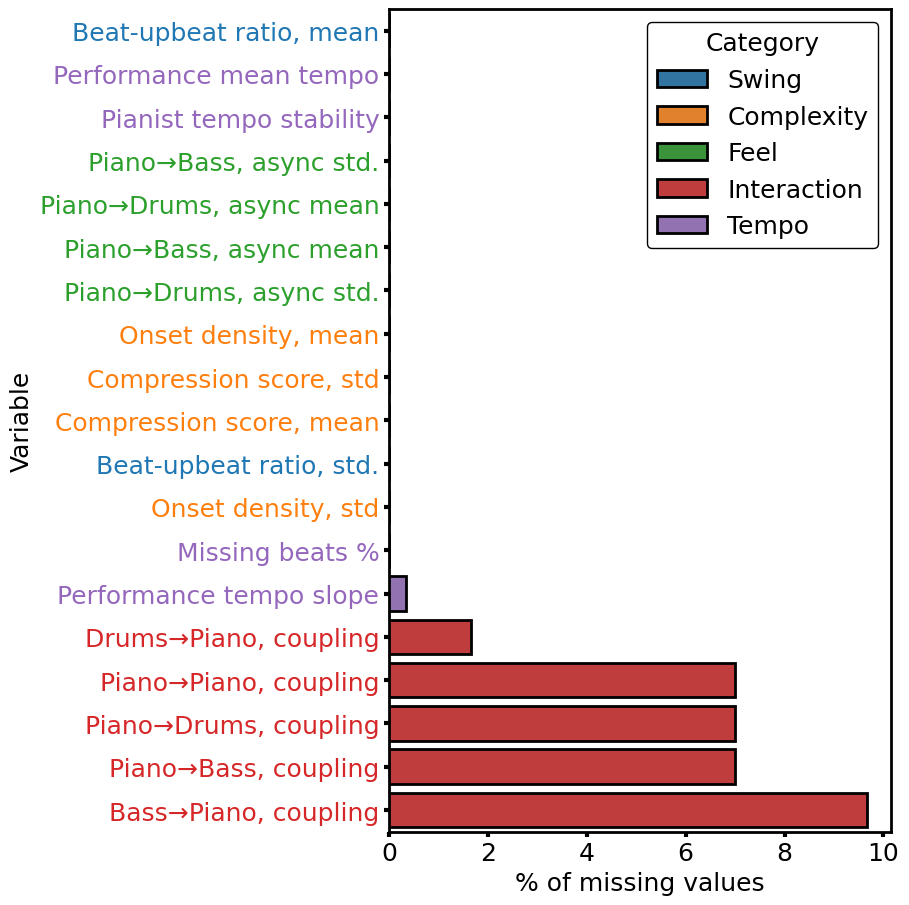

In [24]:
CountPlotMissingValues(clean[PREDICTORS], CATEGORY_MAPPING).create_plot()
plt.show()

### Impute missing values based on feature average
We can now set missing values to the average for that feature across the entire dataset.

In [25]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())

Let's check that we've filled all missing values

In [26]:
X[PREDICTORS].isna().sum().sum()

0

### Encode categorical prediction variable
Next, we need to encode our predictor variable (currently a list of names) to integers.

In [27]:
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

## Random Forest modelling
### Create the model class
We use a custom wrapper around the sklearn `RandomForestClassifier` in order to provide support for various additional features, e.g. grouped permutation importance.

In [28]:
class RandomForestFit:
    """Provides a wrapper around `StratifiedKFold` and `RandomForestClassifier`"""
    col_idxs = [[0, 1], [2, 3, 4, 5], [6, 7, 8, 9], [10, 11, 12, 13, 14], [15, 16, 17]]

    def __init__(self, params: dict = None, skip_feature_importance: bool = False):
        self.params = params if params is not None else {}
        # Will make optimization quicker, we only want accuracy here
        self.skip_feature_importance = skip_feature_importance
        # I think we can probably shuffle the data first.
        # The data is unordered (not time-series), so unlikely to have a negative effect
        self.skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)
        self.predicts, self.importances, self.grouped_importances = [], [], []
        self.trees = []

    def fit_model(
            self,
            x_data,
            y_data
    ):
        fits = [self._fit_model(x_data, y_data, x_idx, y_idx) for x_idx, y_idx in self.skf.split(x_data, y_data)]
        if self.skip_feature_importance:
            self.predicts = self._format_predicts_df(fits)
        else:
            predicts, feature_importances, grouped_importance = list(zip(*fits))
            self.predicts = self._format_predicts_df(predicts)
            self.importances = self._format_importances_df(feature_importances)
            self.grouped_importances = pd.concat(grouped_importance, axis=1)
        return self

    def get_global_accuracy(self) -> float:
        """Returns the percentage of correct predictions"""
        return self.predicts['correct'].value_counts(normalize=True)[True]

    @staticmethod
    def _format_importances_df(
            importances
    ) -> pd.DataFrame:
        importances_df_ = (
            pd.concat(importances, axis=1)
            .reset_index(drop=False)
            .rename(columns={'index': 'feature'})
        )
        importances_df_['category'] = importances_df_['feature'].map(CATEGORY_MAPPING)
        return importances_df_

    @staticmethod
    def _format_predicts_df(
            predicts
    ) -> pd.DataFrame:
        predict_df_ = (
            pd.concat(predicts, axis=0)
            .sort_index()
            .rename(columns={0: 'prediction', 'pianist': 'actual'})
        )
        predict_df_['correct'] = predict_df_['prediction'] == predict_df_['actual']
        for var in ['prediction', 'actual']:
            predict_df_[var] = predict_df_[var].map({i: val for i, val in enumerate(pianist_labels)})
        return predict_df_

    def _fit_model(
            self,
            x_data,
            y_data,
            train_idx,
            test_idx
    ):
        # Get our splits for this fold
        X_train, X_test = x_data.iloc[train_idx], x_data.iloc[test_idx]
        y_train, y_test = y_data[train_idx], y_data[test_idx]
        # Create the random forest model
        rf = RandomForestClassifier(random_state=SEED, **self.params)
        # Fit the random forest to the training data
        rf.fit(X_train, y_train)
        self.trees.append(rf)
        # Predict the test data
        y_predict = rf.predict(X_test)
        # Get prediction probabilities
        y_probs = rf.predict_proba(X_test)
        if self.skip_feature_importance:
            return self._format_predict_df(y_predict, y_probs, y_test)
        else:
            # Calculate importance of individual features
            fpi = self.permutation_importance(rf, X_test, y_test)
            # Calculate importance of feature groups
            gpi = self.grouped_permutation_importance(rf, X_test, y_test)
            # Return the prediction and feature importance dataframes
            return (
                self._format_predict_df(y_predict, y_probs, y_test),
                pd.DataFrame(fpi.importances, index=X.columns),
                pd.DataFrame(gpi.importances, index=PREDICTORS_CATEGORIES.keys())
            )

    @staticmethod
    def permutation_importance(
            estimator,
            X: pd.DataFrame,
            y: pd.DataFrame,
            n_repeats: int = 200,
            scoring: str = 'accuracy',
            sample_weight: float = None,
            max_samples: float = 1.0
    ) -> dict:
        return permutation_importance(
            estimator, X, y, n_repeats=n_repeats, random_state=SEED, n_jobs=N_JOBS,
            sample_weight=sample_weight, max_samples=max_samples, scoring=scoring
        )

    @staticmethod
    def _format_predict_df(
            predict,
            predict_probs,
            actual
    ):
        y_probs = pd.DataFrame(predict_probs)
        y_probs.columns = y_probs.columns.map({i: val for i, val in enumerate(pianist_labels)})
        y_probs.index = actual.index
        # Format the prediction series
        y_predict_s = pd.Series(predict)
        y_predict_s.index = actual.index
        # Concatenate the predicted and actual pianist
        return pd.concat([y_predict_s, actual, y_probs], axis=1)

    @staticmethod
    def _grouped_permutation_score(
        estimator,
        X,
        y,
        sample_weight,
        col_idxs,
        random_state,
        n_repeats,
        scorer,
    ):
        def permute(stat):
            random_state = check_random_state(stat)
            X_permuted = X.copy()
            shuffling_idx = np.arange(X_permuted.shape[0])
            random_state.shuffle(shuffling_idx)
            col = X_permuted.iloc[shuffling_idx, col_idxs]
            col.index = X_permuted.index
            X_permuted[X_permuted.columns[col_idxs]] = col
            return _weights_scorer(scorer, estimator, X_permuted, y, sample_weight)
    
        with Parallel(n_jobs=-1, verbose=1) as par:
            scores = par(delayed(permute)(i) for i in range(n_repeats))
        return np.array(scores)
    
    def grouped_permutation_importance(
            self,
            estimator,
            X: pd.DataFrame,
            y: pd.DataFrame,
            random_state: float = SEED,
            n_repeats: int = 40,
            scoring: str = 'accuracy',
            sample_weight: float = None
    ) -> dict:
        random_state = check_random_state(random_state)
        random_seed = random_state.randint(np.iinfo(np.int32).max + 1)
        scorer = check_scoring(estimator, scoring)
        baseline_score = _weights_scorer(scorer, estimator, X, y, sample_weight)
        scores2 = [self._grouped_permutation_score(
            estimator=estimator, X=X, y=y, col_idxs=col_idx, random_state=random_seed,
            n_repeats=n_repeats, scorer=scorer, sample_weight=sample_weight,
        ) for col_idx in self.col_idxs]
        return _create_importances_bunch(baseline_score, np.array(scores2))


### Get baseline accuracy
Here, we just guess a random pianist for each track

In [29]:
accuracy_random = accuracy_score(y, np.random.randint(y.min(), y.max(), len(y)))
print(f"Random guess accuracy: {accuracy_random}")

Random guess accuracy: 0.1


As you'd expect with 10 pianists and 30 tracks per pianist, we'll be correct one in ten times if we just guess the pianist at random.

### Fit the initial model and get accuracy
Here we just use the default parameters for fitting the model

In [ ]:
rf_init = RandomForestFit().fit_model(X, y)

In [31]:
print(f'Initial model accuracy: {rf_init.get_global_accuracy()}')

Initial model accuracy: 0.5666666666666667


### Parameter optimization
Now, we can try and optimize the model using a randomized search over an array of parameters

In [34]:
# These are the parameters we'll sample from when optimizing
test_params = dict(
    # The number of trees to grow in the forest
    n_estimators=[i for i in range(10, 1001, 1)],
    # Max number of features considered for splitting a node
    max_features=[None, 'sqrt', 'log2'],
    # Max number of levels in each tree
    max_depth=[None, *[i for i in range(1, 101, 1)]],
    # Minimum number of samples required to split a node
    min_samples_split=[i for i in range(2, 11)],
    # Minimum number of samples required at each leaf node
    min_samples_leaf=[i for i in range(1, 11)],
    # Whether to sample data points with our without replacement
    bootstrap=[True, False],
)

In [35]:
# Create the `ParameterSampler` object for the required number of iterations
sampler = ParameterSampler(test_params, n_iter=N_ITER, random_state=SEED)

In [36]:
def get_cached_tracks() -> list:
    """Tries to get cached optimised parameters, returns an empty list if cannot find"""
    try:
        return utils.load_csv(
            fpath=rf"{utils.get_project_root()}/references/parameter_optimisation",
            fname='rf_opt_rhythm_v2'
        )
    except FileNotFoundError:
        return []

In [37]:
def create_forest(parameters: dict, iteration: int,):
    """Conducts one iteration of parameter optimisation, with given parameter"""
    # Check our cache to see if we've already got results for this iteration
    # As we use a set seed with `ParameterSampler`, we can get results with just the counter
    cached_results = get_cached_tracks()
    try:
        cached_res = [o for o in cached_results if o['iteration'] == iteration][0]
        # assert all(k in cached_res and parameters[k] == cached_res[k] for k in to_check)
    except (IndexError, AssertionError):
        pass
    else:
        return cached_res

    # Create the forest model
    forest = RandomForestFit(params=parameters, skip_feature_importance=True)
    # Fit the model to the data
    forest.fit_model(X, y)
    # Create the results dictionary and save
    results_dict = {
        'accuracy': forest.get_global_accuracy(),
        'iteration': iteration,
        **parameters
    }
    utils.save_csv(
        results_dict,
        rf"{utils.get_project_root()}/references/parameter_optimisation",
        'rf_opt_rhythm_v2'
    )
    # Return the fitted forest object
    return results_dict

In [38]:
# Use lazy parallelization to create the forest and fit to the data
with Parallel(n_jobs=N_JOBS, verbose=5) as parallel:
    rfs_fitted = parallel(delayed(create_forest)(params, num) for num, params in enumerate(sampler))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:   53.3s
[Parallel(n_jobs=-1)]: Done 402 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 600 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 834 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1410 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1752 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 2130 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2994 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 3480 tasks      | elapsed: 13.1min
[Parallel(n_jobs=-1)]: Done 4002 tasks      | elapsed: 15.2min
[Parallel(n_jobs=-1)]: Done 4560 tasks      | e

### Get the optimized parameters

In [39]:
# Create a dataframe of parameters and accuracy scores
opt_df = pd.DataFrame(rfs_fitted)
opt_df.head()

,accuracy,iteration,n_estimators,min_samples_split,min_samples_leaf,max_features,max_depth,bootstrap
0,0.533333,0,811,7,7,sqrt,84.0,False
1,0.536667,1,255,8,4,log2,78.0,True
2,0.516667,2,26,10,3,log2,49.0,True
3,0.563333,3,948,7,3,log2,32.0,False
4,0.523333,4,642,7,8,log2,99.0,True


In [40]:
# Get the parameter combination that yielded the best accuracy
best_params = opt_df[opt_df['accuracy'] == opt_df['accuracy'].max()][test_params.keys()].to_dict('records')[0]
best_params['max_depth'] = int(best_params['max_depth'])

In [41]:
best_params

{'n_estimators': 114,
 'max_features': 'log2',
 'max_depth': 86,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'bootstrap': True}

So the optimization process doesn't have to be re-run each time, the final parameter set is hard coded below:

In [29]:
# BEST_PARAMS_RAND = {
#     'n_estimators': 626,
#     'max_features': 'sqrt',
#     'max_depth': 36,
#     'min_samples_split': 6,
#     'min_samples_leaf': 1,
#     'bootstrap': True
# }
BEST_PARAMS_RAND = {'n_estimators': 114,
 'max_features': 'log2',
 'max_depth': 86,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'bootstrap': True
}

### Fit the optimized model and get accuracy
Now, we use the best combination of parameters from our optimization process

In [30]:
rf_opt = RandomForestFit(params=BEST_PARAMS_RAND).fit_model(X, y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 out of  40 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parall

In [31]:
print(f'Optimized model accuracy: {rf_opt.get_global_accuracy()}')

Optimized model accuracy: 0.59


## Serialise model and save

In [77]:
rf_all = RandomForestClassifier(random_state=SEED, **BEST_PARAMS_RAND)
rf_all.fit(X, clean[PREDICTION])
dump(rf_all, f'{utils.get_project_root()}/models/pianist_predictor_rhythm.joblib')

['/home/hwc31/Cambridge-Jazz-Trio-Database/models/pianist_predictor_rhythm.joblib']

# t-SNE clustering
This is for our javascript visualisation

## Get predicted probabilities with leave-one-out approach

In [27]:
from src.clean.clean_utils import return_timestamp

y_ = clean[PREDICTION]
def fitter(idx):
    subset = clean.iloc[idx]
    # Get train data
    train_X = X[~X.index.isin([idx])]
    train_y = y_[~y_.index.isin([idx])]
    # Get test data
    test_X = pd.DataFrame(X.iloc[idx]).transpose()
    # Create model
    rf_iter = RandomForestClassifier(random_state=SEED, **BEST_PARAMS_RAND)
    # Fit and append predicted probabilities to list
    rf_iter.fit(train_X, train_y)
    return {
        'link': subset['links']['external'][0],
        'start': return_timestamp(subset['timestamps']['start']),
        'end': return_timestamp(subset['timestamps']['end']),
        'fname': subset['fname'],
        'pianist': subset['pianist'],
        'details': f""""{subset['track_name']}" ({subset['recording_year']}) – {subset['pianist']}""",
        **{pianist_labels[num]: val for num, val in enumerate(rf_iter.predict_proba(test_X)[0].tolist())}
    }

In [28]:
with Parallel(n_jobs=-1, verbose=5) as par:
    probas = par(delayed(fitter)(i) for i in range(len(X)))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 264 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  4.6min finished


In [34]:
proba_df = pd.DataFrame(probas)

## Fit t-SNE clustering

In [36]:
smal = []
for lab in pianist_labels:
    smal.append({l: 0 if lab != l else 1 for l in pianist_labels})

In [88]:
from sklearn.manifold import TSNE
big_df = pd.concat([proba_df, pd.DataFrame(smal)]).reset_index(drop=True)
X_tsne = pd.DataFrame(TSNE(perplexity=25, random_state=SEED).fit_transform(big_df[pianist_labels].to_numpy()))
X_tsne.columns = ['x', 'y']

In [ ]:
plt.scatter(X_tsne['x'], X_tsne['y'])
plt.show()

In [80]:
from sklearn.preprocessing import MinMaxScaler
mm = MinMaxScaler(feature_range=(10, 1080))
X_tsne['x_'] = mm.fit_transform(X_tsne['x'].to_numpy().reshape(-1, 1))
mm = MinMaxScaler(feature_range=(10, 480))
X_tsne['y_'] = mm.fit_transform(X_tsne['y'].to_numpy().reshape(-1, 1))

In [81]:
big_df['prediction'] = big_df[big_df.columns[3:]].apply(
    lambda x: ', '.join(sorted([f'{p.split(" ")[1]}: {int(x[p] * 100)}%' for p in pianist_labels])),
    axis=1
)

In [82]:
for_render = pd.concat([big_df[['link', 'details', 'prediction', 'pianist', 'start', 'end', 'fname', *pianist_labels]], X_tsne[['x_', 'y_']]], axis=1)

In [83]:
for_render['color'] = for_render['pianist'].map({pian: col for pian, col in zip(pianist_labels, plt.rcParams['axes.prop_cycle'].by_key()['color'])})

## Output HTML

In [ ]:
txt = ''
root = "https://raw.githubusercontent.com/HuwCheston/Jazz-Trio-Database/main/references/images/musicians/"
for idx, row in list(for_render.iterrows())[300:]:
    lab = pianist_labels[idx - 300]
    col = plt.rcParams['axes.prop_cycle'].by_key()['color'][idx - 300]
    fpath = root + lab.lower().replace(' ', '_') + '.png'
    txt += f"""<div id=item{idx+1} title="{idx+1}"><img src={fpath} style="bottom: {int(row["y_"])}px; right: {int(row["x_"])}px; position: absolute; height: 60px; width: 60px;"><p style="color: {col}; bottom: {int(row["y_"]) - 30 if row["y_"] > 235 else int(row["y_"]) + 45}px; right: {int(row["x_"])}px; position: absolute">{lab}</div>\n"""

for idx, row in list(for_render.iterrows())[:300]:
    sp = row['pianist'].split(' ')
    ti = sp[0][0] + sp[1][0]
    txt += f"""<div id=item{idx+1} onmouseout="mouseOff()" onmouseover="displayTrackDetails('{row["details"].replace('"', '').replace(' (', ', ').replace(')', ' ')}', {(row[[*pianist_labels, 'Ahmad Jamal']].to_numpy() * 100).astype(int).tolist()})" class="genre scanme" onclick="loadYouTubeVideo('{row['link'].split('=')[-1]}', {int(row["x_"])}, {int(row["y_"])}, {int(row["start"])}, {int(row["end"])}, '{row["fname"]}')" style="color:{row["color"]}; bottom: {int(row["y_"])}px; right: {int(row["x_"])}px;" title="{idx+1}"><b><i>{ti}</i></b><br></div>\n"""

with open(f'{utils.get_project_root()}/html_output_.html', 'w') as f:
    f.write(txt)

## Plot results
### Create confusion matrix and dendrogram
Which pianists was the model best in identifying? Where did it get confused?

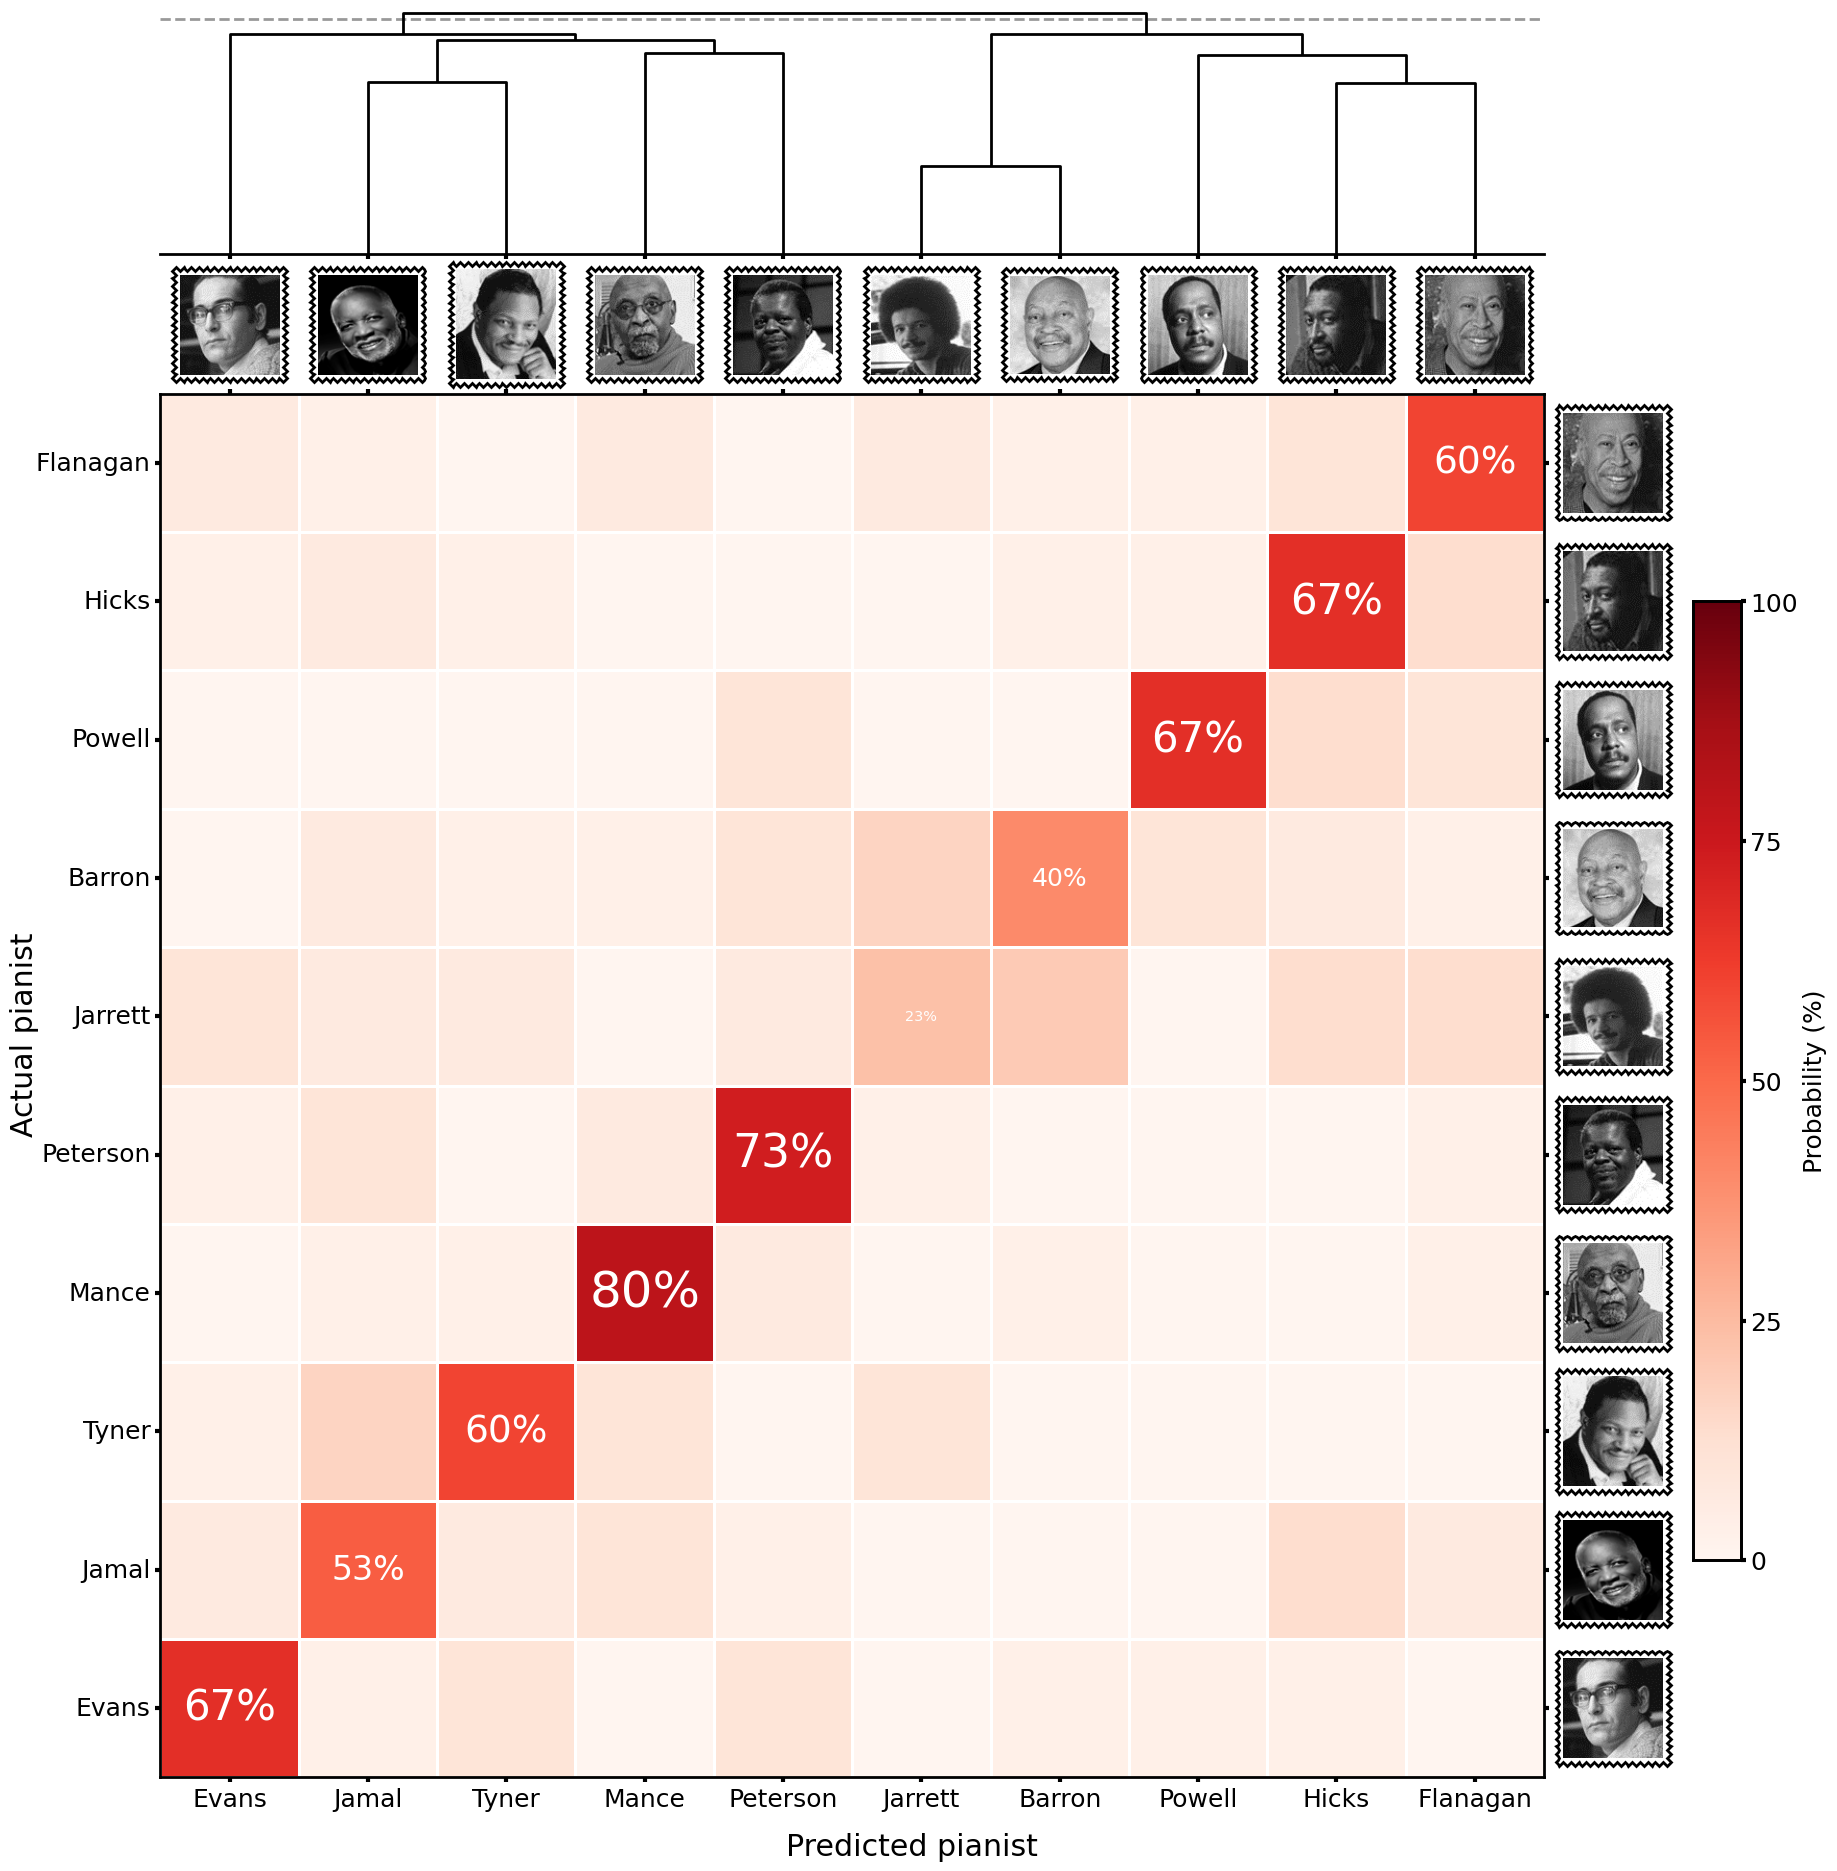

In [32]:
HeatMapPredictionProbDendro(rf_opt.predicts, include_images=True).create_plot()
plt.show()

### Get accuracy scores
Mean accuracy, top-k (`k=3`) accuracy, Cohen's kappa

In [33]:
from sklearn.metrics import top_k_accuracy_score, accuracy_score, cohen_kappa_score, confusion_matrix
act = rf_opt.predicts['actual'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
pred = rf_opt.predicts['prediction'].map({v: k for k, v in enumerate(rf_opt.predicts['actual'].unique())}).values
probs = rf_opt.predicts[pianist_labels].values
print('Mean accuracy:', accuracy_score(act, pred))
print('Top-k accuracy:', top_k_accuracy_score(act, probs, k=3))
print('Cohen kappa:', cohen_kappa_score(act, pred))

Mean accuracy: 0.59
Top-k accuracy: 0.8
Cohen kappa: 0.5444444444444445


### Get feature importances
Grouped permutation importances

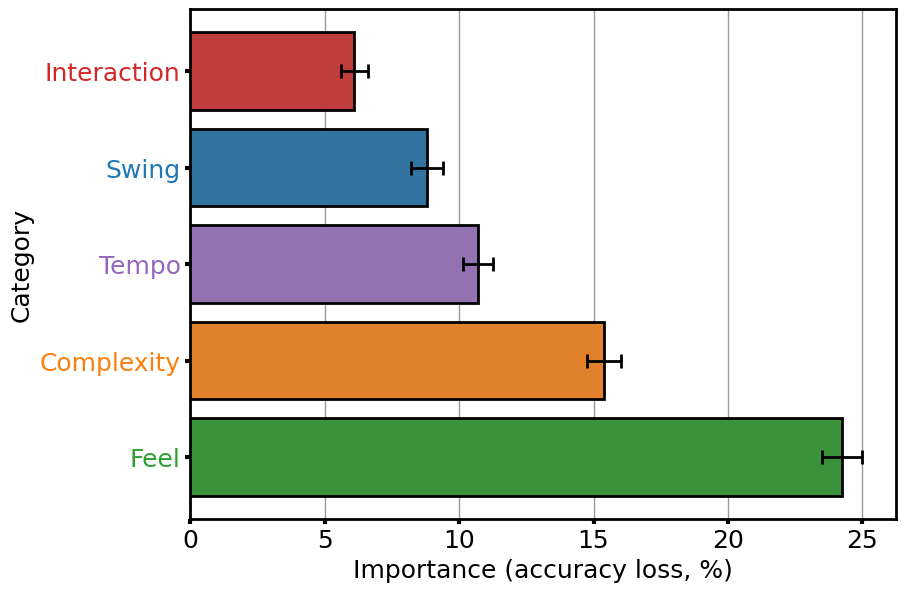

In [34]:
BarPlotCategoryImportances(rf_opt.grouped_importances).create_plot()
plt.show()

Individual feature permutation importances

In [124]:
df.groupby('pianist')['missing_beats_perc'].describe()

,count,mean,std,min,25%,50%,75%,max
pianist,,,,,,,,
Ahmad Jamal,30.0,0.315388,0.101960,0.074380,0.256986,0.313050,0.350229,0.553488
Bill Evans,30.0,0.290612,0.081618,0.096257,0.263955,0.297087,0.333831,0.519084
Bud Powell,30.0,0.266457,0.074695,0.105159,0.225124,0.274915,0.330949,0.406250
John Hicks,30.0,0.340169,0.060926,0.216901,0.305170,0.323686,0.363169,0.501548
Junior Mance,30.0,0.212982,0.058743,0.089431,0.171509,0.220055,0.259608,0.309524
Keith Jarrett,30.0,0.285922,0.074132,0.157718,0.224530,0.276156,0.331014,0.449109
Kenny Barron,30.0,0.302971,0.090371,0.107632,0.238351,0.318490,0.353313,0.474801
McCoy Tyner,30.0,0.340658,0.054221,0.223942,0.309612,0.344255,0.378648,0.449422
Oscar Peterson,30.0,0.178477,0.072427,0.007843,0.153045,0.174011,0.207680,0.401575


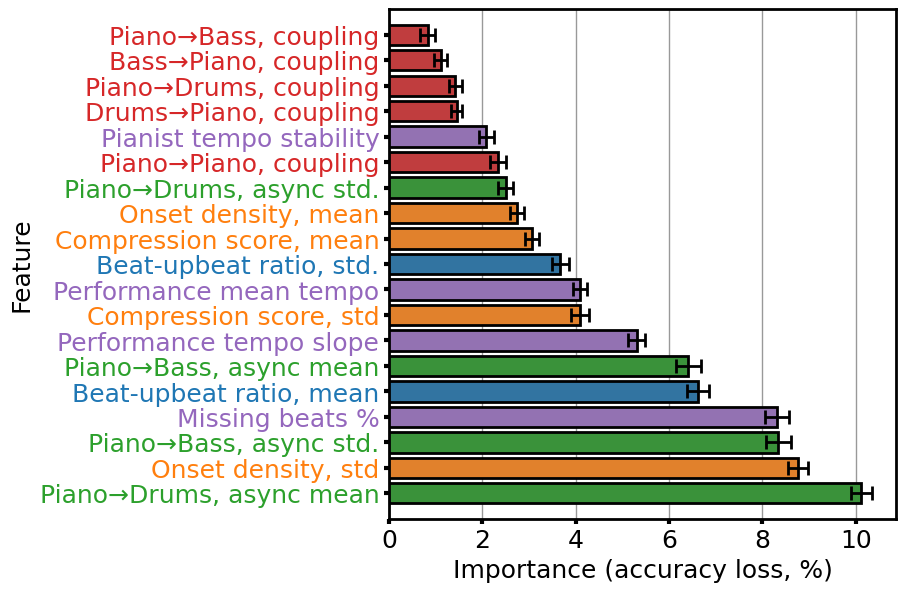

In [35]:
bp = BarPlotFeatureImportances(rf_opt.importances)
bp.create_plot()
plt.show()

## Predicting first and last recordings

In [114]:
X = clean[PREDICTORS].fillna(clean[PREDICTORS].mean())
# We can store the labels for later use
pianist_labels = clean[PREDICTION].unique().tolist()
y = clean[PREDICTION].map({val: i for i, val in enumerate(pianist_labels)})

In [115]:
clean['recording_year_'] = clean['recording_year'].astype(int)

In [116]:
min_idxs = (
    clean.sort_values(by=['pianist', 'recording_year_', 'mbz_id'], ascending=True)
    .groupby('pianist')
    .head(3)
    .index
    .sort_values()
    .to_numpy()
)
max_idxs = (
    clean.sort_values(by=['pianist', 'recording_year_', 'mbz_id'], ascending=False)
    .groupby('pianist')
    .head(3)
    .index
    .sort_values()
    .to_numpy()
)

In [117]:
def minmax_acc(test_idx) -> float:
    train_idx = np.sort(np.array([*(set(X.index) - set(test_idx))]))
    assert not set(test_idx).issubset(set(train_idx))
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    # Create the random forest model
    rf_fl = RandomForestClassifier(random_state=4, **BEST_PARAMS_RAND)
    # Fit the random forest to the training data
    rf_fl.fit(X_train, y_train)
    fl_pred = rf_fl.predict(X_test)
    # Get accuracy for predicting the set
    return accuracy_score(y_test, fl_pred)

min_acc = minmax_acc(min_idxs)
max_acc = minmax_acc(max_idxs)
print(min_acc, max_acc)

0.4666666666666667 0.6333333333333333


In [118]:
def permute_model(rand_state):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.1, random_state=rand_state)
    # Create the random forest model
    rf_rand = RandomForestClassifier(random_state=4, **BEST_PARAMS_RAND)
    # Fit the random forest to the training data
    rf_rand.fit(X_train, y_train)
    rand_pred = rf_rand.predict(X_test)
    return accuracy_score(y_test, rand_pred)

In [119]:
with Parallel(n_jobs=-1, verbose=5) as parallel:
    accs2 = parallel(delayed(permute_model)(state) for state in range(vutils.N_BOOT))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 432 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 756 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 1152 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1620 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 2160 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 2772 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done 3456 tasks      | elapsed:   29.4s
[Parallel(n_jobs=-1)]: Done 4212 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 5040 tasks      | elapsed:   42.7s
[Parallel(n_jobs=-1)]: Done 5940 tasks      | elapsed:   50.4s
[Parallel(n_jobs=-1)]: Done 6912 tasks      | elapsed:   58.5s
[Parallel(n_jobs=-1)]: Done 7956 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 9072 tasks      |

In [120]:
# Baseline accuracu
np.mean(accs2)

0.5644366666666666

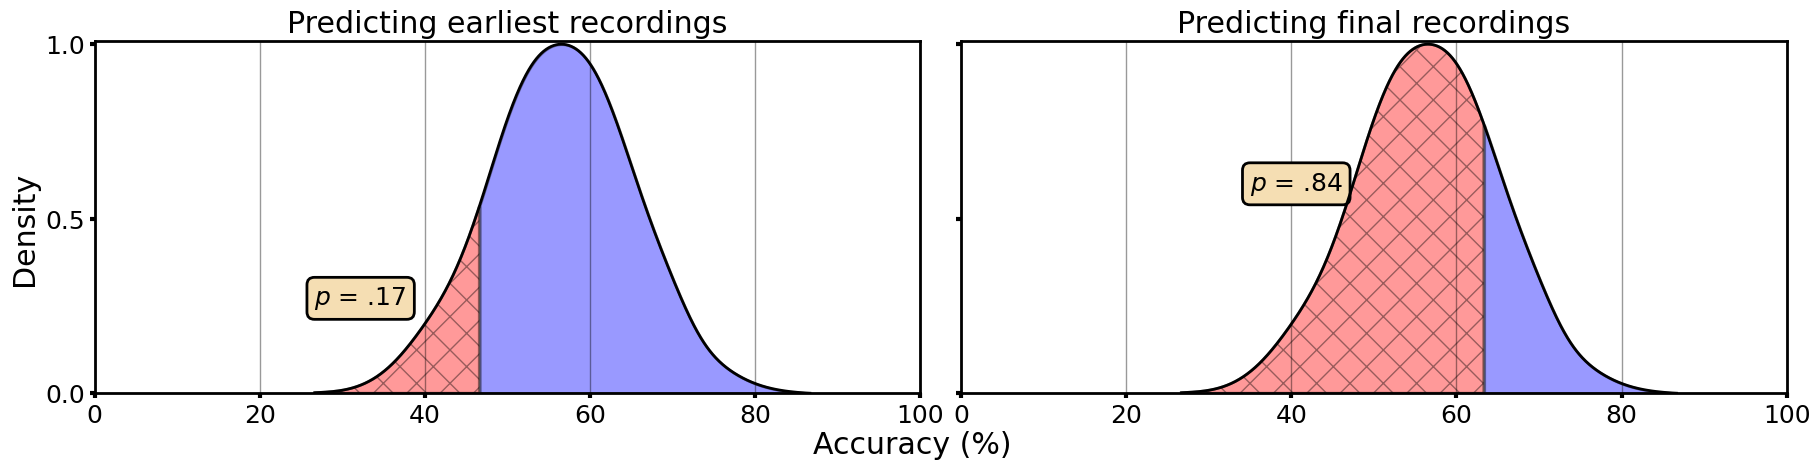

In [121]:
HistPlotFirstLastP(accs2, min_acc, max_acc).create_plot()
plt.show()

## Regressions of age vs strongest predictors

In [32]:
clean['recording_year_'] = clean['recording_year'].astype(int)
clean['career_progress'] = clean.groupby('pianist')['recording_year_'].transform(lambda g: g - g.min())
clean['career_progress'] /= clean['career_progress'].max()
clean['jazz_progress'] = clean['recording_year_'] - clean['recording_year_'].min()
clean['jazz_progress'] /= clean['jazz_progress'].max()

In [41]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

predictors = ['drums_prop_async_nanmean', 'n_onsets_std', 'bur_log_mean', 'missing_beats_perc']
marr = []
conr = []
for predict in predictors:
    vars_ = [predict, 'pianist', 'career_progress', 'jazz_progress']
    data = clean.copy(deep=True)
    data[predict] = stats.zscore(data[predict].fillna(data[predict].mean()))
    md = smf.mixedlm(
        f'{predict}~career_progress+jazz_progress', 
        groups=data['pianist'], 
        data=data, 
        re_formula='~jazz_progress'
    ).fit()
    print(md.summary())
    # Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
    var_fixed = md.predict().var()
    # Variance explained by the random effects
    var_random = float(md.cov_re.to_numpy().mean())
    # Variance of the residuals
    var_resid = md.scale
    # Total variance of the model
    total_var = var_fixed + var_random + var_resid
    # Calculate the r2 values and append to the model
    conr.append((var_fixed + var_random) / total_var)
    marr.append(var_fixed / total_var)
print('mean conditional r2', np.mean(conr) * 100, 'stdev', np.std(conr) * 100)
print('mean marginal r2', np.mean(marr) * 100, 'stdev', np.std(marr) * 100)

                Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: drums_prop_async_nanmean
No. Observations: 300     Method:             REML                    
No. Groups:       10      Scale:              0.5899                  
Min. group size:  30      Log-Likelihood:     -364.6351               
Max. group size:  30      Converged:          Yes                     
Mean group size:  30.0                                                
----------------------------------------------------------------------
                            Coef.  Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------
Intercept                   -0.248    0.434 -0.572 0.567 -1.100  0.603
career_progress             -1.268    0.989 -1.282 0.200 -3.207  0.670
jazz_progress                1.090    1.378  0.791 0.429 -1.610  3.790
Group Var                    0.985    0.785                           
Group x jazz_progress C

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 464 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 752 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1104 tasks      | elapsed:   28.7s
[Parallel(n_jobs=-1)]: Done 1520 tasks      | elapsed:   58.8s
/home/hwc31/.virtualenvs/Cambridge-Jazz-Trio-Database/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/home/hwc31/.virtualenvs/Cambridge-Jazz-Trio-Database/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
[Parallel(n_jobs=-1)]: Done 2000 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2544 tasks      | elapsed:  1.4min
[Parallel(n

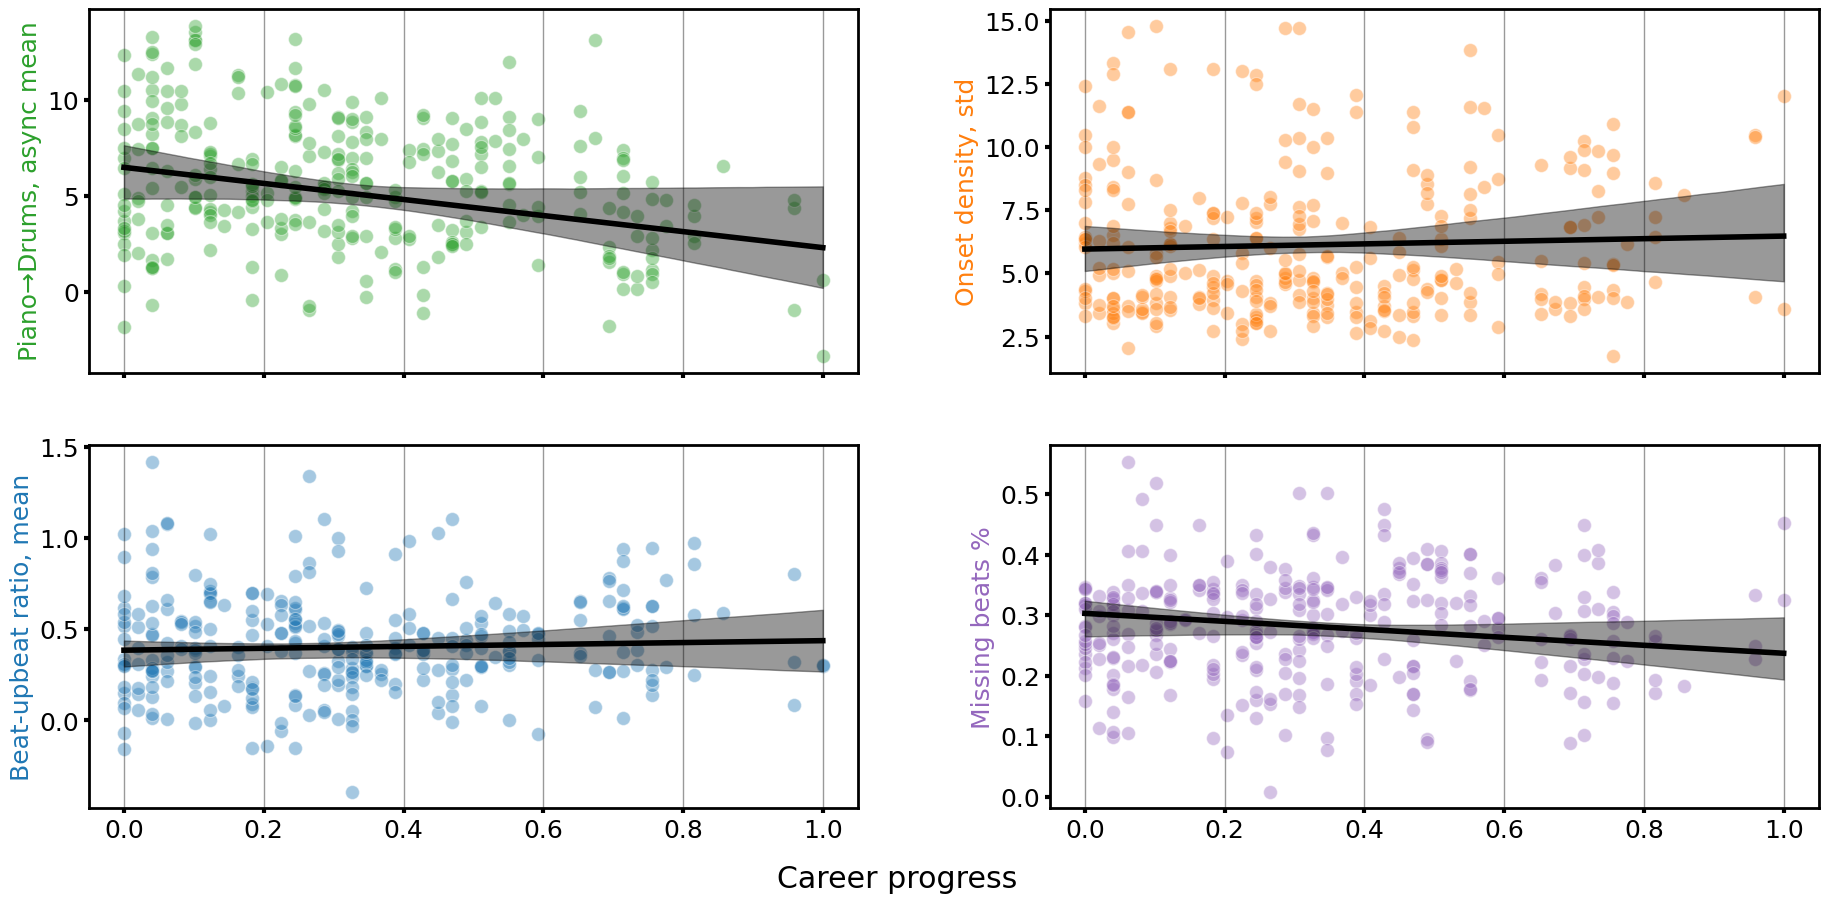

In [42]:
cl = clean.copy(deep=True)
cl['drums_prop_async_nanmean'] = cl['drums_prop_async_nanmean'] * 400
cl['bass_prop_async_nanstd'] = cl['bass_prop_async_nanstd'] * 400
RegPlotCareerJazzProgress(cl, CATEGORY_MAPPING).create_plot()
plt.show()

## Binary logistic regression of two clusters -- impressionistic vs blues

In [44]:
clu1 = ['Bill Evans', 'Oscar Peterson', 'Junior Mance', 'Ahmad Jamal', 'McCoy Tyner']
clu2 = ['Keith Jarrett', 'Kenny Barron', 'Bud Powell', 'John Hicks', 'Tommy Flanagan']

In [45]:
clean.loc[clean['pianist'].isin(clu1), 'cluster'] = 0
clean.loc[clean['pianist'].isin(clu2), 'cluster'] = 1

In [46]:
clean.groupby(['cluster'])['recording_year'].describe()

,count,unique,top,freq
cluster,,,,
0.0,150,41,1960,14
1.0,150,42,1990,10


In [47]:
X = clean[reversed([
    'bass_prop_async_nanmean',
    'bass_prop_async_nanstd',
    'drums_prop_async_nanmean',
    'drums_prop_async_nanstd',
    'tempo',
    'tempo_slope',
    'rolling_std_median',
    'missing_beats_perc',
    'bur_log_mean',
    'bur_log_std',
    'n_onsets_mean',
    'n_onsets_std',
    'lz77_mean',
    'lz77_std',
    'self_coupling',
    'coupling_bass',
    'coupling_drums',
    'coupling_piano_bass',
    'coupling_piano_drums'
])]
X = X.fillna(X.mean()).apply(stats.zscore)
X = sm.add_constant(X)
y = clean['cluster'].astype(int)

In [48]:
md = sm.Logit(y, X).fit()
print(md.summary())

Optimization terminated successfully.
         Current function value: 0.405839
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                cluster   No. Observations:                  300
Model:                          Logit   Df Residuals:                      280
Method:                           MLE   Df Model:                           19
Date:                Mon, 02 Sep 2024   Pseudo R-squ.:                  0.4145
Time:                        17:15:33   Log-Likelihood:                -121.75
converged:                       True   LL-Null:                       -207.94
Covariance Type:            nonrobust   LLR p-value:                 9.693e-27
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -0.0103      0.170     -0.061      0.952      -0.343

In [49]:
y_pred = md.predict(X)
print(accuracy_score(y, y_pred.round().astype(int)))
print(roc_auc_score(y, y_pred))
print(roc_auc_score(y, np.random.choice([0, 1], 300)))

0.8133333333333334
0.8976888888888889
0.53


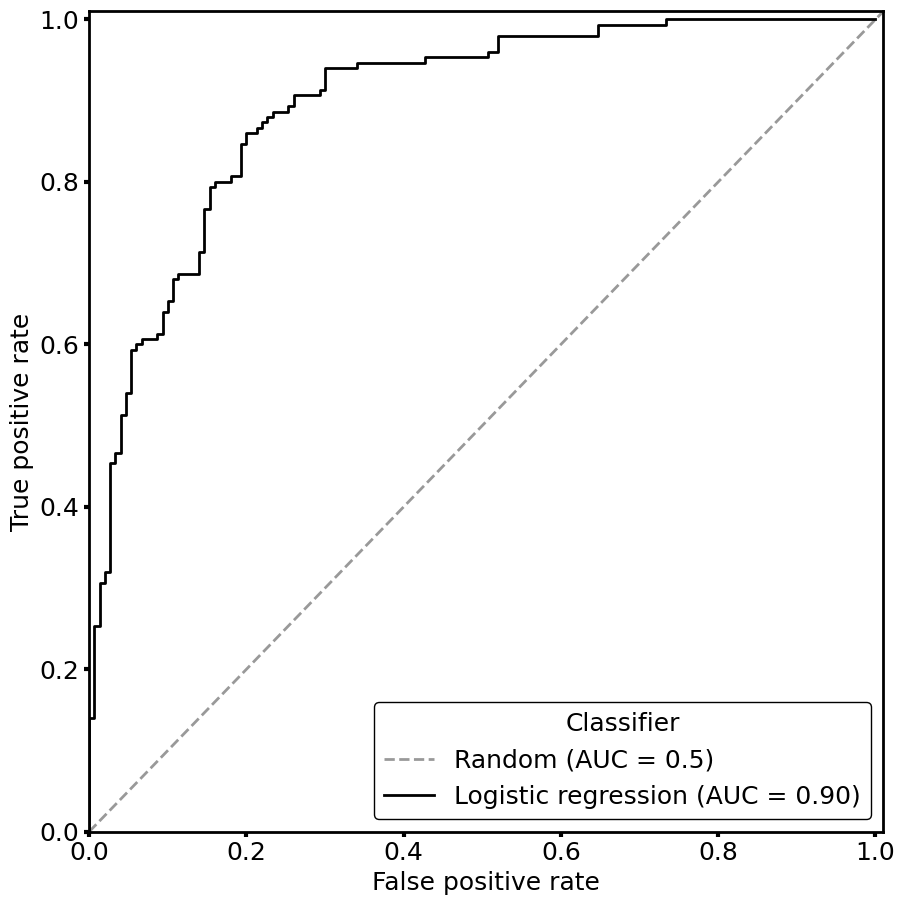

In [50]:
RocPlotLogRegression(y, y_pred).create_plot()
plt.show()

In [51]:
params = pd.concat([md.params.rename('coeff'), md.conf_int().rename(columns={0: 'low', 1: 'high'})], axis=1).apply(np.exp).reset_index(drop=False)[1:]
# params['low'] = params['coeff'] - params['low']
# params['high'] -= params['coeff']
params['category'] = params['index'].map(CATEGORY_MAPPING)

In [52]:
params

,index,coeff,low,high,category
1,coupling_piano_drums,0.920774,0.607000,1.396747,Interaction
2,coupling_piano_bass,0.995215,0.671195,1.475656,Interaction
3,coupling_drums,1.421070,0.778512,2.593976,Interaction
4,coupling_bass,1.444874,0.831639,2.510295,Interaction
5,self_coupling,0.613972,0.408767,0.922192,Interaction
6,lz77_std,0.420980,0.232015,0.763847,Complexity
7,lz77_mean,1.266406,0.598493,2.679703,Complexity
8,n_onsets_std,0.538299,0.276515,1.047920,Complexity
9,n_onsets_mean,0.880543,0.356145,2.177080,Complexity
10,bur_log_std,1.244075,0.744973,2.077556,Swing


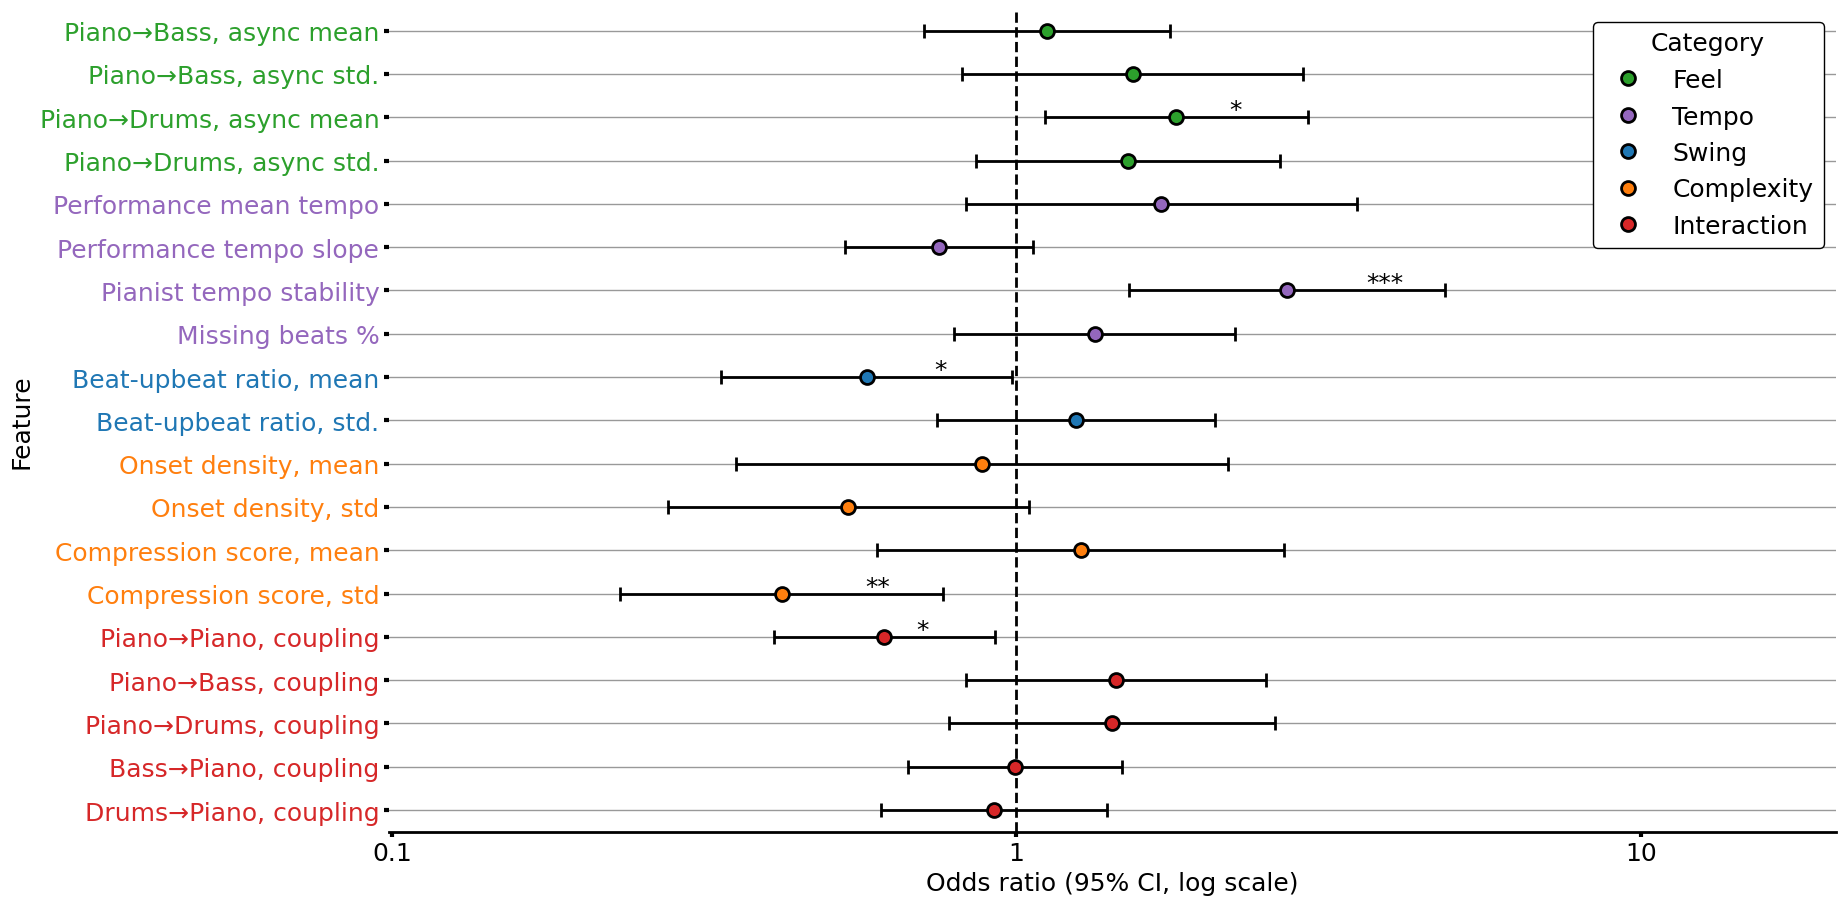

In [53]:
sp = StripPlotLogitCoeffs(md, category_mapping=CATEGORY_MAPPING)
sp.create_plot()
plt.show()